# Imbalanced classes — pre-processing

In [14]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import EasyEnsemble
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, classification_report

# Define a function for plotting data.
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
    plt.show()

## Example problem

Below (following the example shown in the introduction) an imblanced classification problem is produced using the cresent moon dataset generator from *sklean* and the routines from *imblearn* that take a dataset and make it imbalanced.

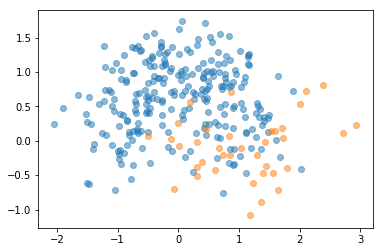

In [2]:
# Based on the imbalance_learn package examples
X, y = make_moons(n_samples=500, shuffle=True, noise=0.4, random_state=40)
X_, y_ = make_imbalance(X, y, ratio=0.15, min_c_=1, random_state=40)

plot_data(X_, y_)

The data can be split into training and test sets and then a linear support vector machine fitted. F1-score can then be used to look at the efficacy of the model.

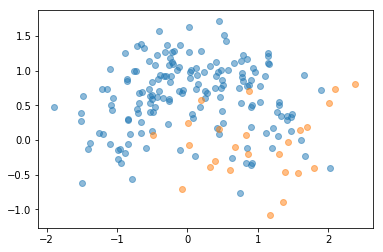

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        83
          1       1.00      0.33      0.50        12

avg / total       0.92      0.92      0.90        95



In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=40, stratify=y_)
plot_data(X_train, y_train)

# Define and fit model
model = SVC(random_state=40, probability=True)
model.fit(X_train, y_train)

# Make predictions
y_predict = model.predict(X_test)

# Output the precision, recall and f1-score
print classification_report(y_true=y_test, y_pred=y_predict)

## Oversampling and undersampling

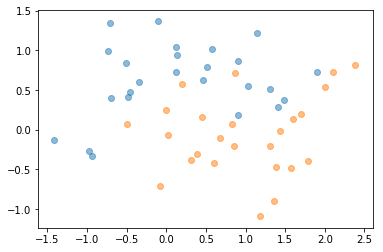

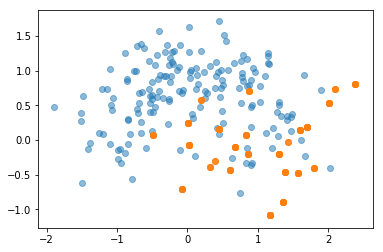

In [4]:
under = RandomUnderSampler(random_state=40)
over = RandomOverSampler(random_state=40)

X_usamp, y_usamp = under.fit_sample(X_train, y_train)
X_osamp, y_osamp = over.fit_sample(X_train, y_train)

plot_data(X_usamp, y_usamp)
plot_data(X_osamp, y_osamp)

In [5]:
model_u = SVC(random_state=40, probability=True)
model_u.fit(X_usamp, y_usamp)

y_upredict = model_u.predict(X_test)

print classification_report(y_true=y_test, y_pred=y_upredict)

             precision    recall  f1-score   support

          0       1.00      0.77      0.87        83
          1       0.39      1.00      0.56        12

avg / total       0.92      0.80      0.83        95



In [6]:
model_o = SVC(random_state=40, probability=True)
model_o.fit(X_osamp, y_osamp)

y_opredict = model_o.predict(X_test)

print classification_report(y_true=y_test, y_pred=y_opredict)

             precision    recall  f1-score   support

          0       1.00      0.75      0.86        83
          1       0.36      1.00      0.53        12

avg / total       0.92      0.78      0.81        95



## Synthetic data

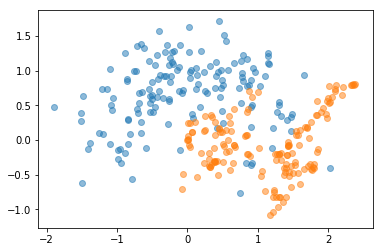

In [7]:
syn = SMOTETomek(random_state=40, smote=SMOTE(k_neighbors=10))

X_syn, y_syn = syn.fit_sample(X_train, y_train)

plot_data(X_syn, y_syn)

In [8]:
model_syn = SVC(random_state=40, probability=True)
model_syn.fit(X_syn, y_syn)

y_spredict = model_syn.predict(X_test)

print classification_report(y_true=y_test, y_pred=y_spredict)

             precision    recall  f1-score   support

          0       1.00      0.75      0.86        83
          1       0.36      1.00      0.53        12

avg / total       0.92      0.78      0.81        95



## MetaCost

Domingos introduced MetaCost <sup>[1]</sup>

[1]:https://homes.cs.washington.edu/~pedrod/papers/kdd99.pdf

In [9]:
c01_c10 = (y_==0).sum() / (y_==1).sum()

threshold = 1 / (1 + c01_c10)

def make_prediction(data, model, threshold):
    probs = model.predict_proba(data)
    return [1 if prob[1] > threshold else 0 for prob in probs]

In [10]:
y_new = make_prediction(X_train, model, threshold)

# Define and fit model
model = SVC(random_state=40, probability=True)
model.fit(X_train, y_new)

# Make predicts
y_predict = model.predict(X_test)

# Output the precision, recall and f1-score
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.97      0.92      0.94        83
          1       0.59      0.83      0.69        12

avg / total       0.93      0.91      0.91        95



In [11]:
# Function for calculating the mean
def mean(x):
    return sum(x)/len(x)

# Define a splitting function
sss = StratifiedShuffleSplit(n_splits=2, random_state=40)

models_probs = []

# Loop over each sub sample
for x in sss.split(X_train, y_train):
    
    # Extract the X and y samples
    X_samp = X_train[x[0]]
    y_samp = y_train[x[0]]
    
    # Fit the model
    model = model.fit(X_samp, y_samp)
    
    # Produce probabilities
    prob_both = model.predict_proba( X_train )
    
    # Only keep minority probabilities
    prob_1 = [prob[1] for prob in prob_both]
    
    models_probs.append(prob_1)


# Get the mean probability for the training classes
probs = map(mean, zip(*models_probs))

# Predict the classes
classes = [1 if prob > threshold else 0 for prob in probs]

# Train model on new classes
model = model.fit(X_train, classes)

# Make predictions
y_predict = model.predict(X_test)
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.97      0.93      0.95        83
          1       0.62      0.83      0.71        12

avg / total       0.93      0.92      0.92        95



## Balanced ensembles

In [12]:
# Define an ensemble function
ee = EasyEnsemble(n_subsets=3, random_state=40)
X_ee, y_ee = ee.fit_sample(X_train, y_train)

models = []

# Loop over each sub sample
for x in xrange(0, len(X_ee)):
    
    # Extract the X and y samples
    X_samp = X_ee[x]
    y_samp = y_ee[x]
    
    # Fit the model
    model = model.fit(X_samp, y_samp)
    models.append(model)
    
def ensemble_prediction(X_test, models):
    
    predictions = []
    for model in models:
        predict = model.predict(X_test)
        predictions.append(predict)
    
    y_predict = map(mean, zip(*predictions))
    y_predict = [1 if y>=0.5 else 0 for y in y_predict]
    
    return y_predict
    
print X_samp.shape, X_train.shape
# Make predictions
y_predict = ensemble_prediction(X_test, models)
print classification_report(y_true=y_test, y_pred=y_predict)

(50, 2) (192, 2)
             precision    recall  f1-score   support

          0       1.00      0.77      0.87        83
          1       0.39      1.00      0.56        12

avg / total       0.92      0.80      0.83        95



In [13]:
model = BalancedBaggingClassifier(base_estimator=SVC(random_state=40, probability=True))

model.fit(X_train, y_train)

# Make predicts
y_predict = model.predict(X_test)
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       1.00      0.75      0.86        83
          1       0.36      1.00      0.53        12

avg / total       0.92      0.78      0.81        95

